# Monitor Prototype

## Analysis india.gov.in

### Fetch urls from the domain

In [1]:
from bs4 import BeautifulSoup
import requests
def fetch_urls_from_sitemap(domain):
    sitemap_url = f"https://{domain}/sitemap.xml"
    urls = set()

    resp = requests.get(sitemap_url, timeout=10)
    if resp.status_code != 200:
        return urls

    soup = BeautifulSoup(resp.text, "xml")
    for loc in soup.find_all("loc"):
        urls.add(loc.text.strip())

    return urls

In [2]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from collections import deque
all_urls = fetch_urls_from_sitemap('india.gov.in')

In [3]:
len(all_urls)

56

In [13]:
all_urls_txt = "\n".join(sorted(all_urls))
with open("all_urls.txt", "w") as f:
    f.write(all_urls_txt)


In [12]:
all_urls = [x.replace("http", "https") for x in all_urls]

### Fetch monitoring metrics

In [14]:
with open("./data/txt/all_urls.txt", "r") as f:
    all_urls = set(line.strip() for line in f if line.strip())
print(len(all_urls), "URLs loaded from all_urls.txt")

56 URLs loaded from all_urls.txt


In [ ]:

import requests
import ssl
import socket
import time
from urllib.parse import urlparse
import datetime
from tqdm import tqdm

def assess_availability(url):
    try:
        start_time = time.time()
        headers = {
            "User-Agent": "Mozilla/5.0",
            "Accept": "text/html",
            "Accept-Language": "en-IN,en;q=0.9"
        }
        resp = requests.get(url, headers=headers, timeout=30)
        response_time = time.time() - start_time
        return {
            'status_code': resp.status_code,
            'response_time': response_time,
            'is_available': resp.status_code == 200
        }
    except requests.RequestException as e:
        return {
            'status_code': None,
            'response_time': None,
            'is_available': False,
            'error': str(e)
        }

def assess_security(url):
    parsed = urlparse(url)
    hostname = parsed.hostname
    port = parsed.port or (443 if parsed.scheme == 'https' else 80)
    
    # Check SSL/TLS
    ssl_info = {}
    if parsed.scheme == 'https':
        try:
            context = ssl.create_default_context()
            with socket.create_connection((hostname, port)) as sock:
                with context.wrap_socket(sock, server_hostname=hostname) as ssock:
                    cert = ssock.getpeercert()
                    ssl_info = {
                        'has_ssl': True,
                        'cert_expires': cert['notAfter'],
                        'issuer': cert['issuer'][0][0][1] if cert['issuer'] else None,
                        'days_until_expiry': (datetime.datetime.strptime(cert['notAfter'], '%b %d %H:%M:%S %Y %Z') - datetime.datetime.now()).days,
                        'current_date': datetime.datetime.now().isoformat()
                    }
        except Exception as e:
            ssl_info = {'has_ssl': False, 'error': str(e)}
    else:
        ssl_info = {'has_ssl': False}
    
    try:
        resp = requests.get(url, timeout=30)
        headers = resp.headers
        security_headers = {
            'content_security_policy': 'Content-Security-Policy' in headers,
            'x_frame_options': 'X-Frame-Options' in headers,
            'strict_transport_security': 'Strict-Transport-Security' in headers
        }
    except:
        security_headers = {}
    
    return {
        'ssl_info': ssl_info,
        'security_headers': security_headers
    }

def assess_performance(url):
    try:
        start_time = time.time()
        resp = requests.get(url, timeout=30)
        total_time = time.time() - start_time
        page_size = len(resp.content)
        return {
            'total_load_time': total_time,
            'page_size_bytes': page_size,
            'status_code': resp.status_code
        }
    except requests.RequestException as e:
        return {'error': str(e)}

def assess_accessibility(url):
    try:
        resp = requests.get(url, timeout=30)
        soup = BeautifulSoup(resp.text, 'html.parser')
        has_alt = any(img.get('alt') for img in soup.find_all('img'))
        has_headings = bool(soup.find_all(['h1', 'h2', 'h3']))
        return {
            'has_alt_text': has_alt,
            'has_headings': has_headings,
        }
    except Exception as e:
        return {'error': str(e)}


def assess_urls(urls):
    results = {}
    for url in tqdm(urls):
        results[url] = {}
        results[url]['availability'] = assess_availability(url)
        results[url]['security'] = assess_security(url)
        results[url]['performance'] = assess_performance(url)
        results[url]['accessibility'] = assess_accessibility(url)
    return results


In [10]:
# Run assessments
availability = False
res = None
url = list(all_urls)[0]
url = url.replace("http", "https")
while not availability:
    availability_data = assess_availability(url)
    availability = availability_data['is_available']
    if availability is not None:
        if not availability:
            print(f"Waiting for {url} to become available...")
            time.sleep(5)
        else:
            print(f"{url} is now available.")
            res = availability_data
            availability = True
    else:
        print(f"Error checking availability of {url}, retrying...")
        time.sleep(5)
# results = assess_urls(availability)

https://india.gov.in/category is now available.


In [16]:
results = assess_urls(all_urls)

  0%|          | 0/56 [00:00<?, ?it/s]

Assessed availability for https://india.gov.in/category/jobs, None
Assessed security for https://india.gov.in/category/jobs, True
Assessed performance for https://india.gov.in/category/jobs, 0.5275833606719971


  2%|▏         | 1/56 [00:32<29:55, 32.65s/it]

Assessed accessibility for https://india.gov.in/category/jobs, has_alt_text: None
Assessed availability for https://india.gov.in/category/science-it-communication, 200
Assessed security for https://india.gov.in/category/science-it-communication, True
Assessed performance for https://india.gov.in/category/science-it-communication, 0.7238025665283203


  4%|▎         | 2/56 [00:35<13:37, 15.15s/it]

Assessed accessibility for https://india.gov.in/category/science-it-communication, has_alt_text: None
Assessed availability for https://india.gov.in/category/citizenship-visa-passports, 200
Assessed security for https://india.gov.in/category/citizenship-visa-passports, True
Assessed performance for https://india.gov.in/category/citizenship-visa-passports, 0.6588654518127441


  5%|▌         | 3/56 [00:38<08:34,  9.70s/it]

Assessed accessibility for https://india.gov.in/category/citizenship-visa-passports, has_alt_text: None
Assessed availability for https://india.gov.in/category/welfare-of-families, 200
Assessed security for https://india.gov.in/category/welfare-of-families, True
Assessed performance for https://india.gov.in/category/welfare-of-families, 0.4553840160369873


  7%|▋         | 4/56 [00:41<06:06,  7.04s/it]

Assessed accessibility for https://india.gov.in/category/welfare-of-families, has_alt_text: None
Assessed availability for https://india.gov.in/category, 200
Assessed security for https://india.gov.in/category, True
Assessed performance for https://india.gov.in/category, 0.6232178211212158


  9%|▉         | 5/56 [00:44<04:40,  5.50s/it]

Assessed accessibility for https://india.gov.in/category, has_alt_text: None
Assessed availability for https://india.gov.in/feedback, 200
Assessed security for https://india.gov.in/feedback, True
Assessed performance for https://india.gov.in/feedback, 0.4744420051574707


 11%|█         | 6/56 [00:46<03:34,  4.30s/it]

Assessed accessibility for https://india.gov.in/feedback, has_alt_text: None
Assessed availability for https://india.gov.in, 200
Assessed security for https://india.gov.in, True
Assessed performance for https://india.gov.in, 0.5431439876556396


 12%|█▎        | 7/56 [00:49<03:11,  3.90s/it]

Assessed accessibility for https://india.gov.in, has_alt_text: None
Assessed availability for https://india.gov.in/category/business-self-employed, 200
Assessed security for https://india.gov.in/category/business-self-employed, True
Assessed performance for https://india.gov.in/category/business-self-employed, None


 14%|█▍        | 8/56 [01:51<18:00, 22.50s/it]

Assessed accessibility for https://india.gov.in/category/business-self-employed, has_alt_text: None
Assessed availability for https://india.gov.in/directory/web-directory, 200
Assessed security for https://india.gov.in/directory/web-directory, True
Assessed performance for https://india.gov.in/directory/web-directory, 0.7577128410339355


 16%|█▌        | 9/56 [01:54<12:48, 16.36s/it]

Assessed accessibility for https://india.gov.in/directory/web-directory, has_alt_text: None
Assessed availability for https://india.gov.in/category/travel-tourism, 200
Assessed security for https://india.gov.in/category/travel-tourism, True
Assessed performance for https://india.gov.in/category/travel-tourism, 0.6860201358795166


 18%|█▊        | 10/56 [01:57<09:19, 12.17s/it]

Assessed accessibility for https://india.gov.in/category/travel-tourism, has_alt_text: None
Assessed availability for https://india.gov.in/news/news-on-air, 200
Assessed security for https://india.gov.in/news/news-on-air, True
Assessed performance for https://india.gov.in/news/news-on-air, 0.5350193977355957


 20%|█▉        | 11/56 [01:59<06:53,  9.19s/it]

Assessed accessibility for https://india.gov.in/news/news-on-air, has_alt_text: None
Assessed availability for https://india.gov.in/faqs, 200
Assessed security for https://india.gov.in/faqs, True
Assessed performance for https://india.gov.in/faqs, 0.4699227809906006


 21%|██▏       | 12/56 [02:02<05:11,  7.08s/it]

Assessed accessibility for https://india.gov.in/faqs, has_alt_text: None
Assessed availability for https://india.gov.in/category/health-wellness, 200
Assessed security for https://india.gov.in/category/health-wellness, True
Assessed performance for https://india.gov.in/category/health-wellness, 0.6705348491668701


 23%|██▎       | 13/56 [02:05<04:12,  5.88s/it]

Assessed accessibility for https://india.gov.in/category/health-wellness, has_alt_text: None
Assessed availability for https://india.gov.in/news/pib-news, 200
Assessed security for https://india.gov.in/news/pib-news, True
Assessed performance for https://india.gov.in/news/pib-news, 0.46860432624816895


 25%|██▌       | 14/56 [02:07<03:23,  4.83s/it]

Assessed accessibility for https://india.gov.in/news/pib-news, has_alt_text: None
Assessed availability for https://india.gov.in/directory/helpline, 200
Assessed security for https://india.gov.in/directory/helpline, True
Assessed performance for https://india.gov.in/directory/helpline, 0.5999336242675781


 27%|██▋       | 15/56 [02:10<02:47,  4.09s/it]

Assessed accessibility for https://india.gov.in/directory/helpline, has_alt_text: None
Assessed availability for https://india.gov.in/explore-india/facts-of-india, 200
Assessed security for https://india.gov.in/explore-india/facts-of-india, True
Assessed performance for https://india.gov.in/explore-india/facts-of-india, 0.5091350078582764


 29%|██▊       | 16/56 [02:12<02:21,  3.53s/it]

Assessed accessibility for https://india.gov.in/explore-india/facts-of-india, has_alt_text: None
Assessed availability for https://india.gov.in/directory/public-utilities, 200
Assessed security for https://india.gov.in/directory/public-utilities, True
Assessed performance for https://india.gov.in/directory/public-utilities, 0.5095605850219727


 30%|███       | 17/56 [02:14<02:02,  3.13s/it]

Assessed accessibility for https://india.gov.in/directory/public-utilities, has_alt_text: None
Assessed availability for https://india.gov.in/calendar, 200
Assessed security for https://india.gov.in/calendar, True
Assessed performance for https://india.gov.in/calendar, 0.6192045211791992


 32%|███▏      | 18/56 [02:16<01:49,  2.88s/it]

Assessed accessibility for https://india.gov.in/calendar, has_alt_text: None
Assessed availability for https://india.gov.in/explore-india/odop, 200
Assessed security for https://india.gov.in/explore-india/odop, True
Assessed performance for https://india.gov.in/explore-india/odop, 0.530372142791748


 34%|███▍      | 19/56 [02:18<01:38,  2.66s/it]

Assessed accessibility for https://india.gov.in/explore-india/odop, has_alt_text: None
Assessed availability for https://india.gov.in/app-privacy-policy, 200
Assessed security for https://india.gov.in/app-privacy-policy, True
Assessed performance for https://india.gov.in/app-privacy-policy, 0.6123933792114258


 36%|███▌      | 20/56 [02:21<01:29,  2.49s/it]

Assessed accessibility for https://india.gov.in/app-privacy-policy, has_alt_text: None
Assessed availability for https://india.gov.in/about-us, 200
Assessed security for https://india.gov.in/about-us, True
Assessed performance for https://india.gov.in/about-us, 0.5470399856567383


 38%|███▊      | 21/56 [02:23<01:22,  2.36s/it]

Assessed accessibility for https://india.gov.in/about-us, has_alt_text: None
Assessed availability for https://india.gov.in/disclaimer, 200
Assessed security for https://india.gov.in/disclaimer, True
Assessed performance for https://india.gov.in/disclaimer, 0.6099820137023926


 39%|███▉      | 22/56 [02:25<01:19,  2.34s/it]

Assessed accessibility for https://india.gov.in/disclaimer, has_alt_text: None
Assessed availability for https://india.gov.in/my-government/acts-and-rule, 200
Assessed security for https://india.gov.in/my-government/acts-and-rule, True
Assessed performance for https://india.gov.in/my-government/acts-and-rule, 0.6041216850280762


 41%|████      | 23/56 [02:27<01:16,  2.33s/it]

Assessed accessibility for https://india.gov.in/my-government/acts-and-rule, has_alt_text: None
Assessed availability for https://india.gov.in/directory/contact-directory, 200
Assessed security for https://india.gov.in/directory/contact-directory, True
Assessed performance for https://india.gov.in/directory/contact-directory, 0.541914701461792


 43%|████▎     | 24/56 [02:29<01:13,  2.29s/it]

Assessed accessibility for https://india.gov.in/directory/contact-directory, has_alt_text: None
Assessed availability for https://india.gov.in/newsletter-subscription/subscribe, 200
Assessed security for https://india.gov.in/newsletter-subscription/subscribe, True
Assessed performance for https://india.gov.in/newsletter-subscription/subscribe, 0.4713404178619385


 45%|████▍     | 25/56 [02:32<01:08,  2.22s/it]

Assessed accessibility for https://india.gov.in/newsletter-subscription/subscribe, has_alt_text: None
Assessed availability for https://india.gov.in/explore-india/culinary-delights, 200
Assessed security for https://india.gov.in/explore-india/culinary-delights, True
Assessed performance for https://india.gov.in/explore-india/culinary-delights, 0.6063137054443359


 46%|████▋     | 26/56 [02:34<01:05,  2.20s/it]

Assessed accessibility for https://india.gov.in/explore-india/culinary-delights, has_alt_text: None
Assessed availability for https://india.gov.in/category/driving-transport, 200
Assessed security for https://india.gov.in/category/driving-transport, True
Assessed performance for https://india.gov.in/category/driving-transport, 0.5815165042877197


 48%|████▊     | 27/56 [02:37<01:12,  2.50s/it]

Assessed accessibility for https://india.gov.in/category/driving-transport, has_alt_text: None
Assessed availability for https://india.gov.in/category/youth-sports-culture, 200
Assessed security for https://india.gov.in/category/youth-sports-culture, True
Assessed performance for https://india.gov.in/category/youth-sports-culture, 0.6812295913696289


 50%|█████     | 28/56 [02:40<01:16,  2.74s/it]

Assessed accessibility for https://india.gov.in/category/youth-sports-culture, has_alt_text: None
Assessed availability for https://india.gov.in/newsletter, 200
Assessed security for https://india.gov.in/newsletter, True
Assessed performance for https://india.gov.in/newsletter, 0.3931312561035156


 52%|█████▏    | 29/56 [02:42<01:07,  2.51s/it]

Assessed accessibility for https://india.gov.in/newsletter, has_alt_text: None
Assessed availability for https://india.gov.in/news/pib-photographs, 200
Assessed security for https://india.gov.in/news/pib-photographs, True
Assessed performance for https://india.gov.in/news/pib-photographs, 0.44475865364074707


 54%|█████▎    | 30/56 [02:44<01:02,  2.42s/it]

Assessed accessibility for https://india.gov.in/news/pib-photographs, has_alt_text: None
Assessed availability for https://india.gov.in/category/housing-local-services, 200
Assessed security for https://india.gov.in/category/housing-local-services, True
Assessed performance for https://india.gov.in/category/housing-local-services, 1.1596269607543945


 55%|█████▌    | 31/56 [02:49<01:13,  2.96s/it]

Assessed accessibility for https://india.gov.in/category/housing-local-services, has_alt_text: None
Assessed availability for https://india.gov.in/directory/whos-who, 200
Assessed security for https://india.gov.in/directory/whos-who, True
Assessed performance for https://india.gov.in/directory/whos-who, 3.726202964782715


 57%|█████▋    | 32/56 [02:56<01:39,  4.16s/it]

Assessed accessibility for https://india.gov.in/directory/whos-who, has_alt_text: None
Assessed availability for https://india.gov.in/services, 200
Assessed security for https://india.gov.in/services, True
Assessed performance for https://india.gov.in/services, 0.5635879039764404


 59%|█████▉    | 33/56 [02:58<01:20,  3.52s/it]

Assessed accessibility for https://india.gov.in/services, has_alt_text: None
Assessed availability for https://india.gov.in/explore-india/travel-and-tourism, 200
Assessed security for https://india.gov.in/explore-india/travel-and-tourism, True
Assessed performance for https://india.gov.in/explore-india/travel-and-tourism, 0.45540595054626465


 61%|██████    | 34/56 [03:00<01:08,  3.10s/it]

Assessed accessibility for https://india.gov.in/explore-india/travel-and-tourism, has_alt_text: None
Assessed availability for https://india.gov.in/my-government/documents, 200
Assessed security for https://india.gov.in/my-government/documents, True
Assessed performance for https://india.gov.in/my-government/documents, 0.815805196762085


 62%|██████▎   | 35/56 [03:02<01:01,  2.92s/it]

Assessed accessibility for https://india.gov.in/my-government/documents, has_alt_text: None
Assessed availability for https://india.gov.in/spotlight, 200
Assessed security for https://india.gov.in/spotlight, True
Assessed performance for https://india.gov.in/spotlight, 0.675358772277832


 64%|██████▍   | 36/56 [03:05<00:55,  2.77s/it]

Assessed accessibility for https://india.gov.in/spotlight, has_alt_text: None
Assessed availability for https://india.gov.in/news/dd-news, 200
Assessed security for https://india.gov.in/news/dd-news, True
Assessed performance for https://india.gov.in/news/dd-news, 0.4227018356323242


 66%|██████▌   | 37/56 [03:07<00:48,  2.57s/it]

Assessed accessibility for https://india.gov.in/news/dd-news, has_alt_text: None
Assessed availability for https://india.gov.in/category/education-learning, 200
Assessed security for https://india.gov.in/category/education-learning, True
Assessed performance for https://india.gov.in/category/education-learning, 0.5797505378723145


 68%|██████▊   | 38/56 [03:10<00:50,  2.80s/it]

Assessed accessibility for https://india.gov.in/category/education-learning, has_alt_text: None
Assessed availability for https://india.gov.in/directory, 200
Assessed security for https://india.gov.in/directory, True
Assessed performance for https://india.gov.in/directory, 0.5288355350494385


 70%|██████▉   | 39/56 [03:12<00:45,  2.65s/it]

Assessed accessibility for https://india.gov.in/directory, has_alt_text: None
Assessed availability for https://india.gov.in/link-to-us, 200
Assessed security for https://india.gov.in/link-to-us, True
Assessed performance for https://india.gov.in/link-to-us, 0.49286961555480957


 71%|███████▏  | 40/56 [03:15<00:41,  2.57s/it]

Assessed accessibility for https://india.gov.in/link-to-us, has_alt_text: None
Assessed availability for https://india.gov.in/category/defence-foreign-affairs, 200
Assessed security for https://india.gov.in/category/defence-foreign-affairs, True
Assessed performance for https://india.gov.in/category/defence-foreign-affairs, 0.9935939311981201


 73%|███████▎  | 41/56 [03:48<02:56, 11.73s/it]

Assessed accessibility for https://india.gov.in/category/defence-foreign-affairs, has_alt_text: None
Assessed availability for https://india.gov.in/category/justice-law-grievances, 200
Assessed security for https://india.gov.in/category/justice-law-grievances, True
Assessed performance for https://india.gov.in/category/justice-law-grievances, 0.5121221542358398


 75%|███████▌  | 42/56 [03:51<02:10,  9.29s/it]

Assessed accessibility for https://india.gov.in/category/justice-law-grievances, has_alt_text: None
Assessed availability for https://india.gov.in/category/governance-planning, 200
Assessed security for https://india.gov.in/category/governance-planning, True
Assessed performance for https://india.gov.in/category/governance-planning, 0.6942298412322998


 77%|███████▋  | 43/56 [03:55<01:37,  7.49s/it]

Assessed accessibility for https://india.gov.in/category/governance-planning, has_alt_text: None
Assessed availability for https://india.gov.in/help, 200
Assessed security for https://india.gov.in/help, True
Assessed performance for https://india.gov.in/help, 0.4651942253112793


 79%|███████▊  | 44/56 [03:57<01:09,  5.79s/it]

Assessed accessibility for https://india.gov.in/help, has_alt_text: None
Assessed availability for https://india.gov.in/category/benefits-social-development, 200
Assessed security for https://india.gov.in/category/benefits-social-development, True
Assessed performance for https://india.gov.in/category/benefits-social-development, 1.5451693534851074


 80%|████████  | 45/56 [04:01<00:57,  5.27s/it]

Assessed accessibility for https://india.gov.in/category/benefits-social-development, has_alt_text: None
Assessed availability for https://india.gov.in/my-government/constitution-of-india, 200
Assessed security for https://india.gov.in/my-government/constitution-of-india, True
Assessed performance for https://india.gov.in/my-government/constitution-of-india, 0.519310474395752


 82%|████████▏ | 46/56 [04:03<00:43,  4.32s/it]

Assessed accessibility for https://india.gov.in/my-government/constitution-of-india, has_alt_text: None
Assessed availability for https://india.gov.in/explore-india, 200
Assessed security for https://india.gov.in/explore-india, True
Assessed performance for https://india.gov.in/explore-india, 0.941042423248291


 84%|████████▍ | 47/56 [04:06<00:35,  3.99s/it]

Assessed accessibility for https://india.gov.in/explore-india, has_alt_text: None
Assessed availability for https://india.gov.in/my-government/schemes, 200
Assessed security for https://india.gov.in/my-government/schemes, True
Assessed performance for https://india.gov.in/my-government/schemes, 0.5679771900177002


 86%|████████▌ | 48/56 [04:09<00:29,  3.72s/it]

Assessed accessibility for https://india.gov.in/my-government/schemes, has_alt_text: None
Assessed availability for https://india.gov.in/contact-us, 200
Assessed security for https://india.gov.in/contact-us, True
Assessed performance for https://india.gov.in/contact-us, 0.46808552742004395


 88%|████████▊ | 49/56 [04:11<00:22,  3.24s/it]

Assessed accessibility for https://india.gov.in/contact-us, has_alt_text: None
Assessed availability for https://india.gov.in/tell-a-friend, 200
Assessed security for https://india.gov.in/tell-a-friend, True
Assessed performance for https://india.gov.in/tell-a-friend, 0.3757283687591553


 89%|████████▉ | 50/56 [04:14<00:17,  2.99s/it]

Assessed accessibility for https://india.gov.in/tell-a-friend, has_alt_text: None
Assessed availability for https://india.gov.in/visitor-summary, 200
Assessed security for https://india.gov.in/visitor-summary, True
Assessed performance for https://india.gov.in/visitor-summary, 0.5606541633605957


 91%|█████████ | 51/56 [04:16<00:13,  2.77s/it]

Assessed accessibility for https://india.gov.in/visitor-summary, has_alt_text: None
Assessed availability for https://india.gov.in/category/money-taxes, 200
Assessed security for https://india.gov.in/category/money-taxes, True
Assessed performance for https://india.gov.in/category/money-taxes, 0.6116178035736084


 93%|█████████▎| 52/56 [04:19<00:11,  2.89s/it]

Assessed accessibility for https://india.gov.in/category/money-taxes, has_alt_text: None
Assessed availability for https://india.gov.in/category/agriculture-rural-environment, 200
Assessed security for https://india.gov.in/category/agriculture-rural-environment, True
Assessed performance for https://india.gov.in/category/agriculture-rural-environment, 0.6869966983795166


 95%|█████████▍| 53/56 [04:23<00:09,  3.29s/it]

Assessed accessibility for https://india.gov.in/category/agriculture-rural-environment, has_alt_text: None
Assessed availability for https://india.gov.in/category/infrastructure-industries, 200
Assessed security for https://india.gov.in/category/infrastructure-industries, True
Assessed performance for https://india.gov.in/category/infrastructure-industries, 0.6696851253509521


 96%|█████████▋| 54/56 [04:27<00:06,  3.30s/it]

Assessed accessibility for https://india.gov.in/category/infrastructure-industries, has_alt_text: None
Assessed availability for https://india.gov.in/website-policy, 200
Assessed security for https://india.gov.in/website-policy, True
Assessed performance for https://india.gov.in/website-policy, 0.44190216064453125


 98%|█████████▊| 55/56 [04:28<00:02,  2.91s/it]

Assessed accessibility for https://india.gov.in/website-policy, has_alt_text: None
Assessed availability for https://india.gov.in/site-map, 200
Assessed security for https://india.gov.in/site-map, True
Assessed performance for https://india.gov.in/site-map, 0.5200941562652588


100%|██████████| 56/56 [04:31<00:00,  4.84s/it]

Assessed accessibility for https://india.gov.in/site-map, has_alt_text: None


In [ ]:
# results
# import json
# with open("./data/json/url_data/govin/india.json", "w") as f:
#     json.dump(results, f, indent=2)

### Analyze assessment

In [35]:
with open ("./data/json/url_data/govin/india.json", "r") as f:
    data = json.load(f)
import pandas as pd
def get_tables(data):
    tables = {}
    for key in tqdm(data[next(iter(data))]):  # Get the first subdictionary's keys
        # Create a DataFrame for each key
        tables[key] = pd.DataFrame.from_dict(
            {url: data[url][key] for url in tqdm(data)},
            orient='index'
        )
    return tables

data_tables = get_tables(data)


100%|██████████| 4/4 [00:00<00:00, 218.01it/s]


In [36]:
avl_df = data_tables['availability']
sec_df = data_tables['security']
perf_df = data_tables['performance']
acc_df = data_tables['accessibility']

In [37]:
avl_df = avl_df.fillna({'status_code': 0,  'is_available': False})
avl_df['status_code'].value_counts()

status_code
200.0    55
0.0       1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

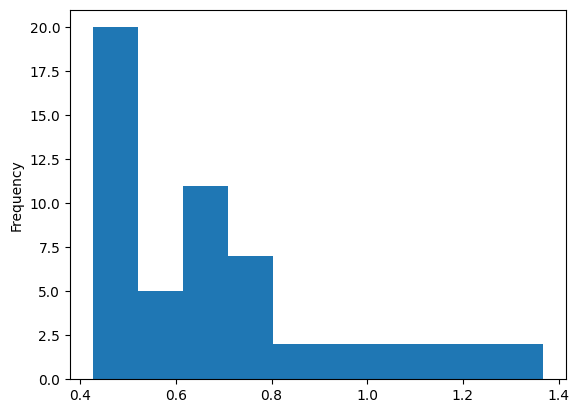

In [39]:
avl_df['response_time'].plot(kind='hist')

In [40]:
sec_df.columns

Index(['ssl_info', 'security_headers'], dtype='object')

In [52]:
"""ssl_info - {'has_ssl': True,
 'cert_expires': 'Jan 25 05:51:18 2026 GMT',
 'issuer': 'US',
 'days_until_expiry': 41,
 'current_date': '2025-12-14T15:16:04.793122'}

 security_headers = {'content_security_policy': True,
 'x_frame_options': True,
 'strict_transport_security': True}
 """

ssl_info_df = sec_df['ssl_info'].apply(lambda x: pd.Series(x))
security_headers_df = sec_df['security_headers'].apply(lambda x: pd.Series(x))
ssl_info_df = pd.concat([ssl_info_df, security_headers_df], axis=1)
ssl_info_df.columns

Index(['has_ssl', 'cert_expires', 'issuer', 'days_until_expiry',
       'current_date', 'content_security_policy', 'x_frame_options',
       'strict_transport_security'],
      dtype='object')

<Axes: ylabel='Frequency'>

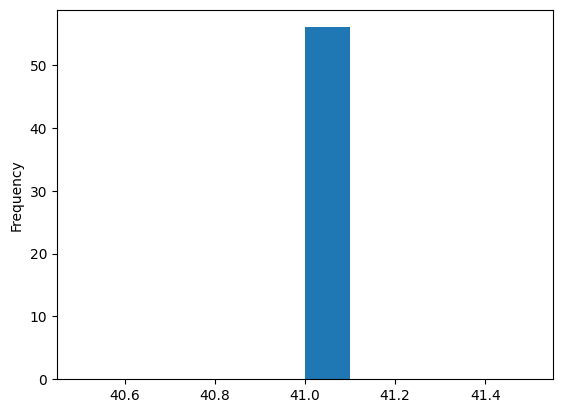

In [53]:
ssl_info_df['days_until_expiry'].plot(kind='hist')

In [54]:
for col in ['has_ssl', 'issuer',
        'content_security_policy', 'x_frame_options',
       'strict_transport_security']:
    print(col)
    print(ssl_info_df[col].value_counts())

has_ssl
has_ssl
True    56
Name: count, dtype: int64
issuer
issuer
US    56
Name: count, dtype: int64
content_security_policy
content_security_policy
True    56
Name: count, dtype: int64
x_frame_options
x_frame_options
True    56
Name: count, dtype: int64
strict_transport_security
strict_transport_security
True    56
Name: count, dtype: int64
